In [ ]:
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import xarray as xr
from sklearn.feature_selection import mutual_info_regression

import config
from utils import plotting, processing

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# suppress warnings from cartopy about downloading data
warnings.filterwarnings("ignore", message=".*Downloading.*", module="cartopy")

In [ ]:
sns.set_theme(style="darkgrid")

In [ ]:
df = pd.read_csv(config.PROCESSED_DATASET_PATH)
df.head()

,storm_id,timestamp,eat_hours,x,y,orography_height,anor,zonal_speed,meridional_speed,area,distance_from_prev,bearing_from_prev,storm_total_duration,storm_max_area,storm_straight_line_distance,storm_bearing,storm_distance_traversed,mjo_phase,mjo_amplitude
0,3992,2014-01-02 14:15:00,17.25,38.900739,6.77762,2560.4673,-0.302176,0.733333,2.004444,485.680556,0.000000,NaN,3.25,1767.877222,40.704616,25.723249,0.000000,5,0.43548
1,3992,2014-01-02 14:30:00,17.50,38.854092,6.77762,2518.0483,-0.347111,0.146667,4.351111,777.088889,5.178423,0.000000,3.25,1767.877222,40.704616,25.723249,5.178423,5,0.43548
2,3992,2014-01-02 14:45:00,17.75,38.854092,6.77762,2518.0483,-0.347111,0.195556,-0.880000,1010.215556,0.000000,0.000000,3.25,1767.877222,40.704616,25.723249,5.178423,5,0.43548
3,3992,2014-01-02 15:00:00,18.00,38.854092,6.77762,2518.0483,-0.347111,-5.035556,4.888889,1321.051111,0.000000,0.000000,3.25,1767.877222,40.704616,25.723249,5.178423,5,0.43548
4,3992,2014-01-02 15:15:00,18.25,38.806765,6.74383,2518.0483,-0.347111,-2.640000,2.053333,1573.605000,6.017631,29.192335,3.25,1767.877222,40.704616,25.723249,11.196055,5,0.43548


In [ ]:
# sort dataframe by datetime and group by storm
storm_groups = df.sort_values(["timestamp"]).groupby("storm_id")
storm_inits = storm_groups.first()

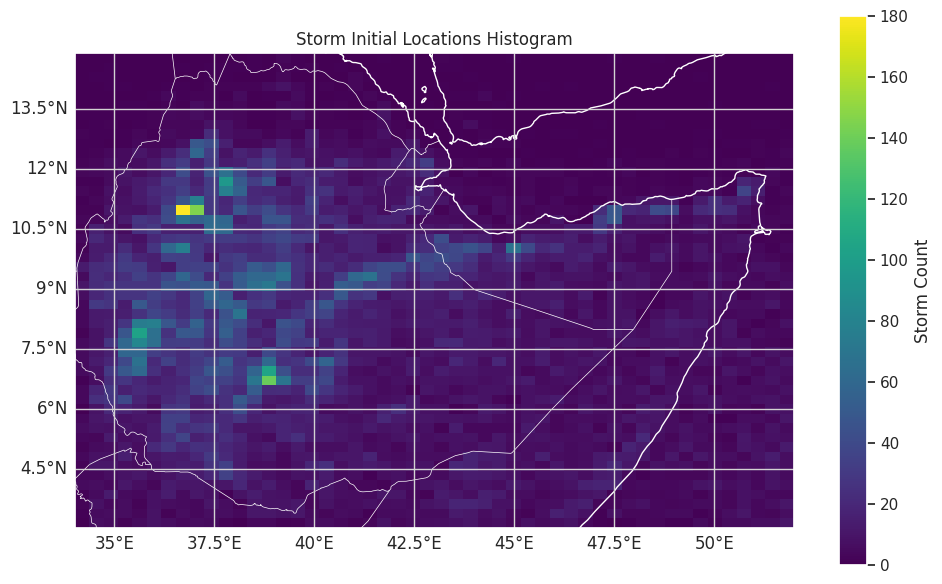

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map()
plotting.add_borders(ax, edgecolor="white")
plotting.add_gridlines(ax)

# https://www.julienphalip.com/blog/drawing-geographical-density-maps-with-matplotlib/
plt.hist2d(storm_inits["x"], storm_inits["y"], bins=50, cmap="viridis")
plt.colorbar(label="Storm Count")

plt.title("Storm Initial Locations Histogram")
plotting.save_plot("storm_init_hist2d.png")

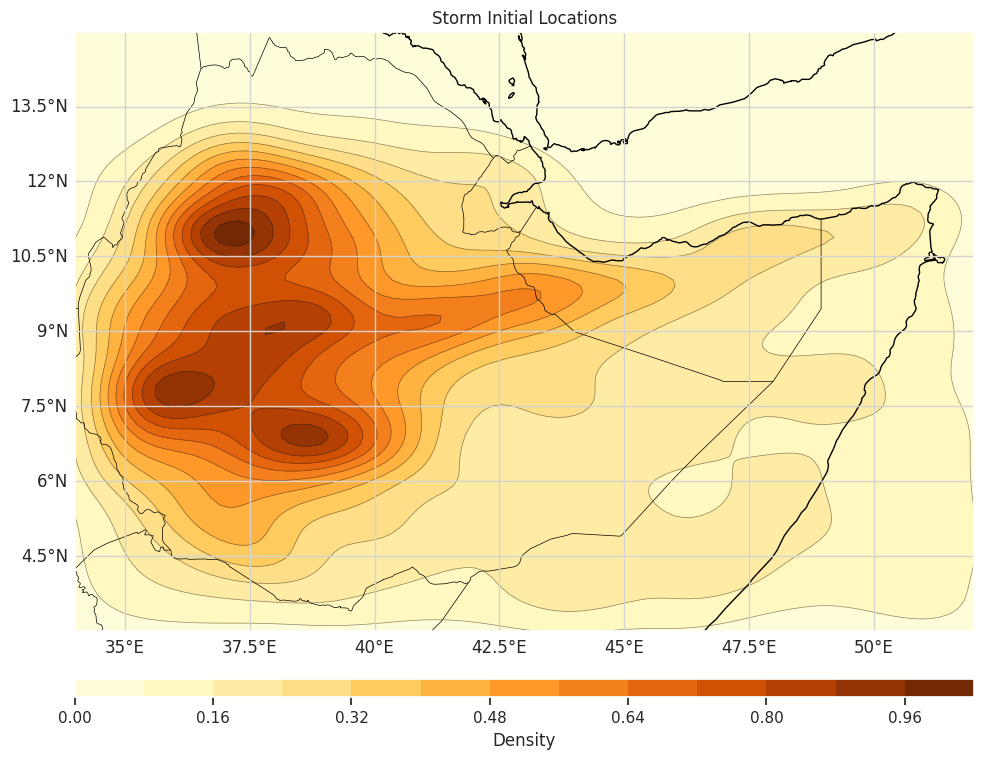

In [ ]:
# 2D kernel density estimation
X, Y, Z = processing.calc_kde(storm_inits["x"], storm_inits["y"])

plt.figure(figsize=(10, 10))
ax = plotting.init_map()

# add filled contours and contour lines
plotting.plot_kde_map(X, Y, Z, ax=ax, colorbar_padding=0.05)

ax.set_title("Storm Initial Locations")
plotting.save_plot("storm_init_kde.png")

In [ ]:
geop, height = processing.load_geop_and_calc_elevation()

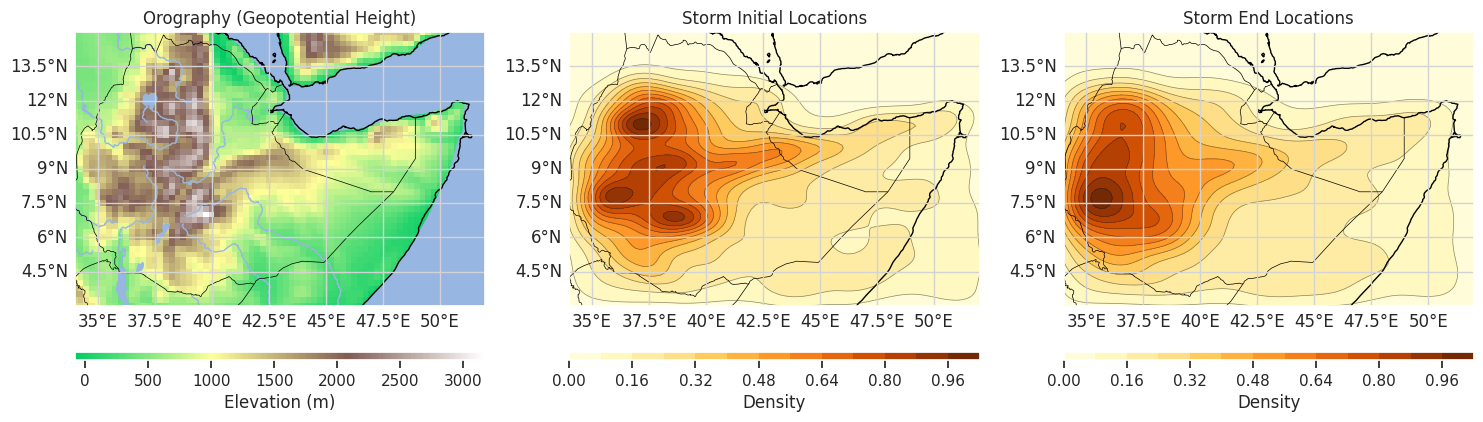

In [ ]:
fig, axs = plt.subplots(
    1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)

# plot the orography
plotting.init_map(axs[0], extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(geop, height, axs[0], add_colorbar=True)
plotting.add_all_map_features(axs[0])
axs[0].set_title("Orography (Geopotential Height)")

# plot storm initial locations
storm_inits_x, storm_inits_y, storm_inits_kde = processing.calc_kde(
    storm_inits["x"], storm_inits["y"]
)
plotting.init_map(axs[1], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_inits_x, storm_inits_y, storm_inits_kde, ax=axs[1])
axs[1].set_title("Storm Initial Locations")

# plot storm end locations
storm_ends = storm_groups.last()
storm_ends_x, storm_ends_y, storm_ends_kde = processing.calc_kde(
    storm_ends["x"], storm_ends["y"]
)
plotting.init_map(axs[2], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_ends_x, storm_ends_y, storm_ends_kde, ax=axs[2])
axs[2].set_title("Storm End Locations")

plotting.save_plot("orography_storm_init_end_kde.png")

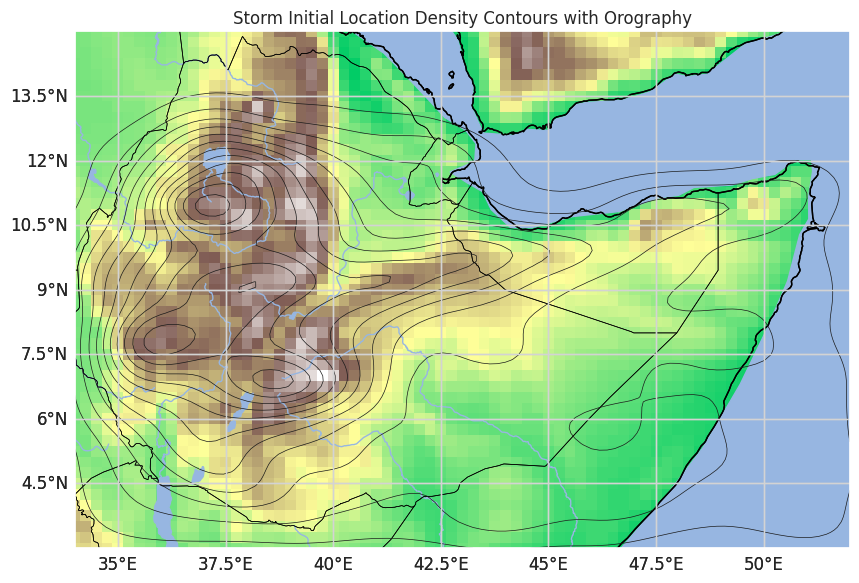

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map(extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(geop, height, ax)
plotting.add_all_map_features(ax)

# plot storm initial locations kde contours
plotting.plot_kde_map(
    storm_inits_x,
    storm_inits_y,
    storm_inits_kde,
    ax=ax,
    contour_lines_only=True,
)

ax.set_title("Storm Initial Location Density Contours with Orography")
plotting.save_plot("orography_storm_init_locations.png")

In [ ]:
anor = xr.open_dataset(config.DATA_DIR / "std" / "anor.nc")

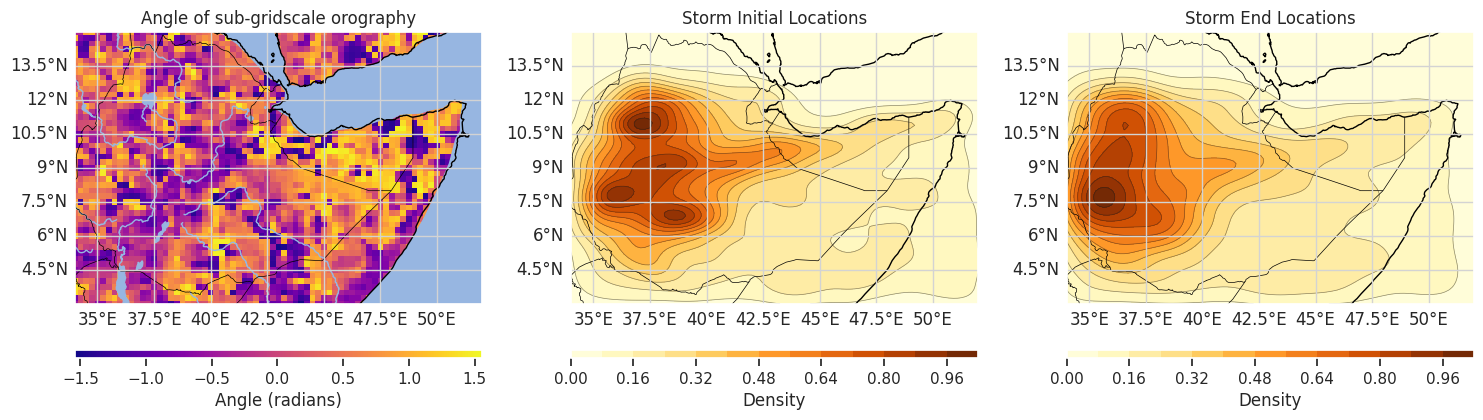

In [ ]:
fig, axs = plt.subplots(
    1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)

# plot the orography
plotting.init_map(axs[0], extent=config.STORM_DATA_EXTENT)
terrain = axs[0].pcolormesh(
    anor["longitude"],
    anor["latitude"],
    anor["anor"][0],
    cmap="plasma",
    transform=ccrs.PlateCarree(),
)
cbar = plt.colorbar(
    terrain, ax=axs[0], orientation="horizontal", pad=0.1, aspect=50
)
cbar.set_label("Angle (radians)")
plotting.add_all_map_features(axs[0])
axs[0].set_title("Angle of sub-gridscale orography")

# plot storm initial locations
storm_inits = storm_groups.first()
storm_inits_x, storm_inits_y, storm_inits_kde = processing.calc_kde(
    storm_inits["x"], storm_inits["y"]
)
plotting.init_map(axs[1], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_inits_x, storm_inits_y, storm_inits_kde, ax=axs[1])
axs[1].set_title("Storm Initial Locations")

# plot storm end locations
storm_ends = storm_groups.last()
storm_ends_x, storm_ends_y, storm_ends_kde = processing.calc_kde(
    storm_ends["x"], storm_ends["y"]
)
plotting.init_map(axs[2], extent=config.STORM_DATA_EXTENT)
plotting.plot_kde_map(storm_ends_x, storm_ends_y, storm_ends_kde, ax=axs[2])
axs[2].set_title("Storm End Locations")

plotting.save_plot("anor_storm_init_end_kde.png")

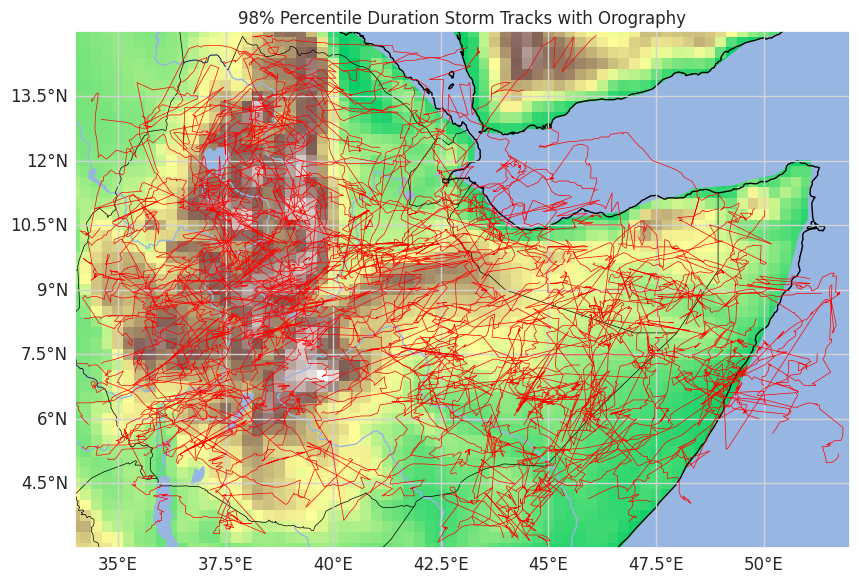

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map(extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(geop, height, ax)
plotting.add_all_map_features(ax)

duration_thres = df["storm_total_duration"].quantile(0.98)
p98_duration_df = df[df["storm_total_duration"] >= duration_thres]
for storm, group in p98_duration_df.groupby("storm_id"):
    ax.plot(
        group["x"],
        group["y"],
        color="red",
        linewidth=0.5,
        transform=ccrs.PlateCarree(),
    )

ax.set_title("98% Percentile Duration Storm Tracks with Orography")
plotting.save_plot("orography_storm_tracks_p98_duration.png")

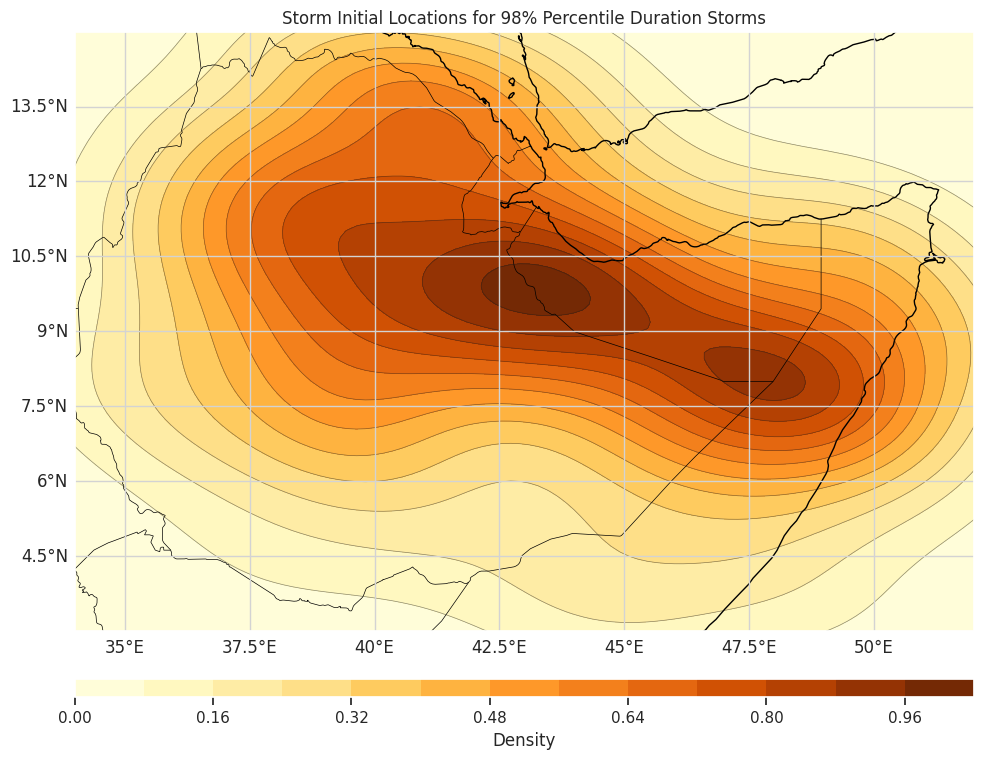

In [ ]:
# 2D kernel density estimation
p98_duration_inits = p98_duration_df.sort_values(["timestamp"]).groupby("storm_id").first()
X, Y, Z = processing.calc_kde(p98_duration_inits["x"], p98_duration_inits["y"])

plt.figure(figsize=(10, 10))
ax = plotting.init_map()

# add filled contours and contour lines
plotting.plot_kde_map(X, Y, Z, ax=ax, colorbar_padding=0.05)

ax.set_title("Storm Initial Locations for 98% Percentile Duration Storms")
plotting.save_plot("p98_duration_storm_init_kde.png")

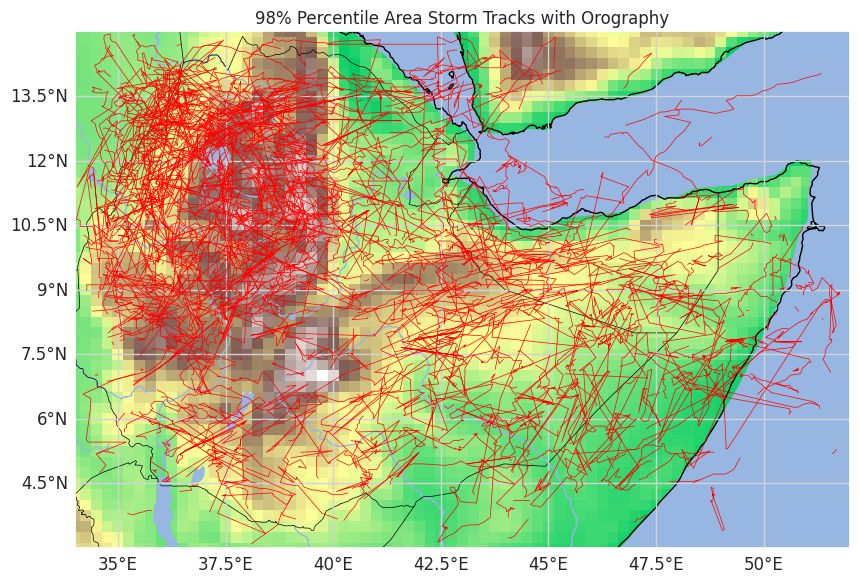

In [ ]:
plt.figure(figsize=(10, 6))
ax = plotting.init_map(extent=config.STORM_DATA_EXTENT)
plotting.add_geopotential_height(geop, height, ax)
plotting.add_all_map_features(ax)

area_thres = df["area"].quantile(0.98)
p98_area_df = df[df["area"] >= area_thres]
for storm, group in p98_area_df.groupby("storm_id"):
    ax.plot(
        group["x"],
        group["y"],
        color="red",
        linewidth=0.5,
        transform=ccrs.PlateCarree(),
    )

ax.set_title("98% Percentile Area Storm Tracks with Orography")
plotting.save_plot("orography_storm_tracks_p98_area.png")

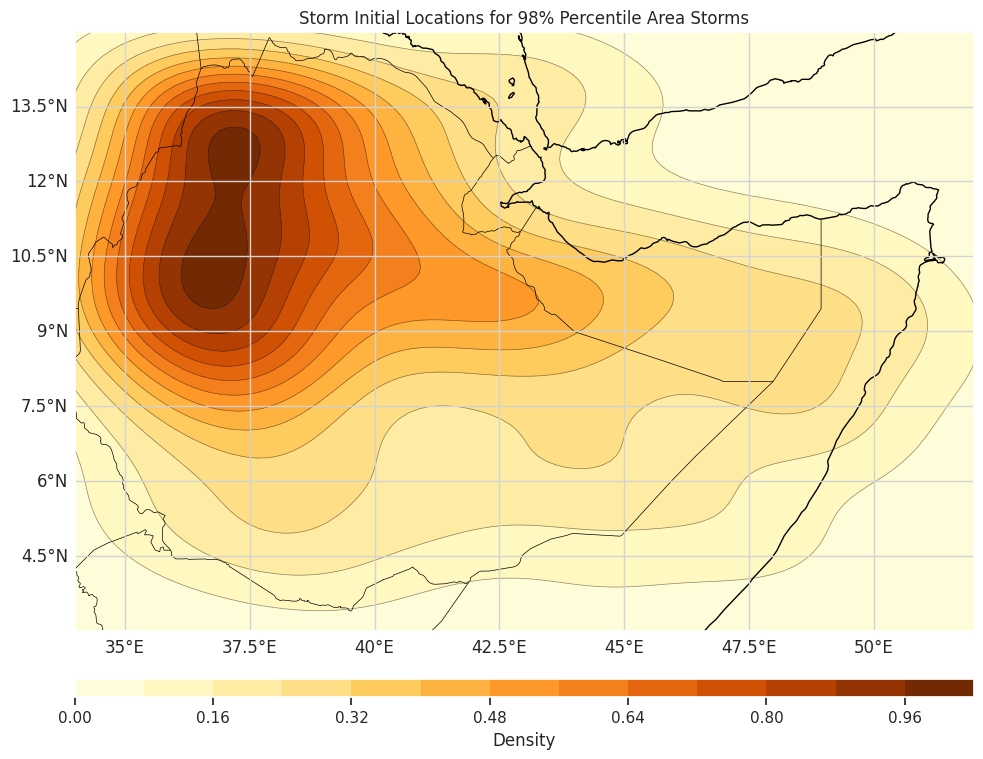

In [ ]:
# 2D kernel density estimation
p98_area_inits = p98_area_df.sort_values(["timestamp"]).groupby("storm_id").first()
X, Y, Z = processing.calc_kde(p98_area_inits["x"], p98_area_inits["y"])

plt.figure(figsize=(10, 10))
ax = plotting.init_map()

# add filled contours and contour lines
plotting.plot_kde_map(X, Y, Z, ax=ax, colorbar_padding=0.05)

ax.set_title("Storm Initial Locations for 98% Percentile Area Storms")
plotting.save_plot("p98_area_storm_init_kde.png")

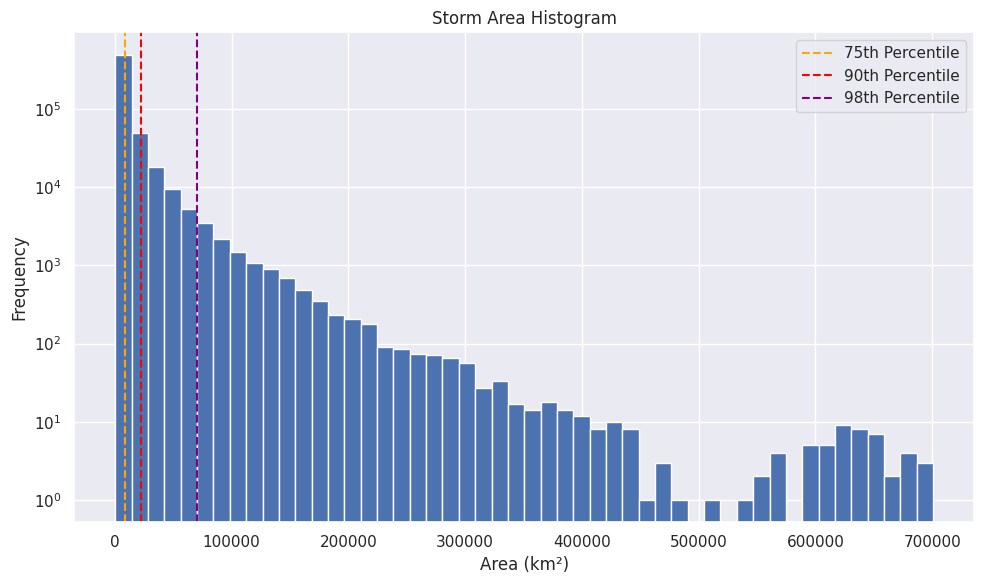

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["area"], bins=50)
plt.yscale("log")

# plot vertical lines for 75, 90, and 98th percentiles
plt.axvline(
    df["area"].quantile(0.75),
    color="orange",
    linestyle="--",
    label="75th Percentile",
)
plt.axvline(
    df["area"].quantile(0.90),
    color="red",
    linestyle="--",
    label="90th Percentile",
)
plt.axvline(
    df["area"].quantile(0.98),
    color="purple",
    linestyle="--",
    label="98th Percentile",
)
plt.legend()

plt.xlabel("Area (km²)")
plt.ylabel("Frequency")
plt.title("Storm Area Histogram")
plotting.save_plot("storm_area_hist.png")

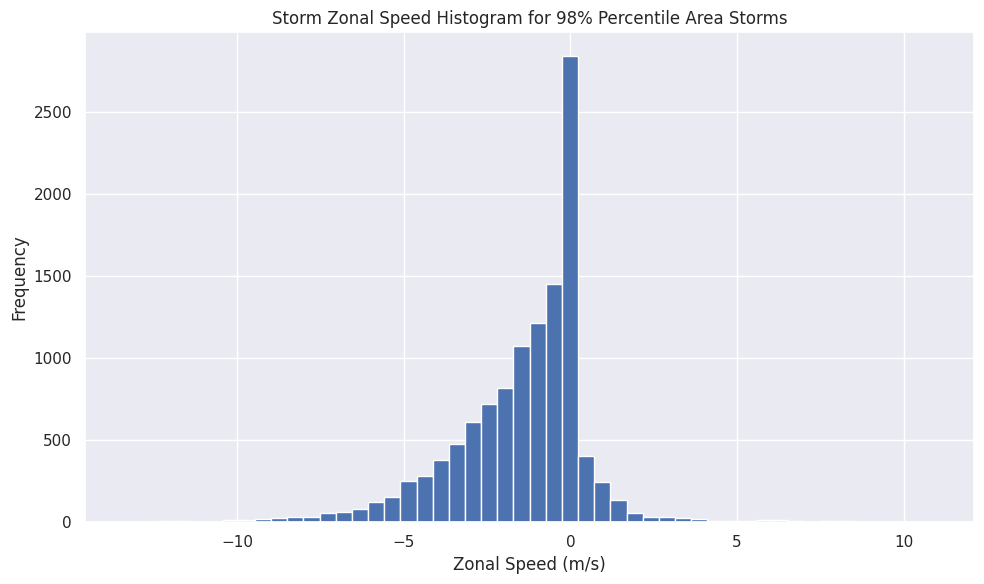

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(p98_area_df["zonal_speed"], bins=50)
plt.xlabel("Zonal Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Storm Zonal Speed Histogram for 98% Percentile Area Storms")
plotting.save_plot("p98_area_storm_zonal_speed_hist.png")

In [ ]:
cardinal_directions = {
    90: "E",
    67.5: "ENE",
    45: "NE",
    22.5: "NNE",
    0: "N",
    337.5: "NNW",
    315: "NW",
    292.5: "WNW",
    270: "W",
    247.5: "WSW",
    225: "SW",
    202.5: "SSW",
    180: "S",
    157.5: "SSE",
    135: "SE",
    112.5: "ESE",
}

In [ ]:
# convert storm bearing to closest cardinal direction
df["storm_closest_cardinal_direction"] = (
    (df["storm_bearing"] % 360) + (22.5/2)
).floordiv(22.5) * 22.5 % 360
df["storm_closest_cardinal_direction"] = df["storm_closest_cardinal_direction"].map(
    cardinal_directions
)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df["storm_closest_cardinal_direction"].value_counts(normalize=True)[list(cardinal_directions.values())],
      theta=list(cardinal_directions.values()),
      fill='toself',
      name='All Storms'
))
p98_area_df = df[df["area"] >= area_thres]
fig.add_trace(go.Scatterpolar(
      r=p98_area_df["storm_closest_cardinal_direction"].value_counts(normalize=True)[list(cardinal_directions.values())],
      theta=list(cardinal_directions.values()),
      fill='toself',
      name='98% Percentile Area Storms'
))
p98_duration_df = df[df["storm_total_duration"] >= duration_thres]
fig.add_trace(go.Scatterpolar(
      r=p98_duration_df["storm_closest_cardinal_direction"].value_counts(normalize=True)[list(cardinal_directions.values())],
      theta=list(cardinal_directions.values()),
      fill='toself',
      name='98% Percentile Duration Storms'
))

# max_r = 0.6
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      # range=[0, max_r],
      # tickvals=np.arange(0, max_r + 0.01, 0.15),
      # tick0=0,
      # dtick=0.25
    )
  ),
  showlegend=True,
  title="Storm Cardinal Directions Distribution",
)

fig.show()

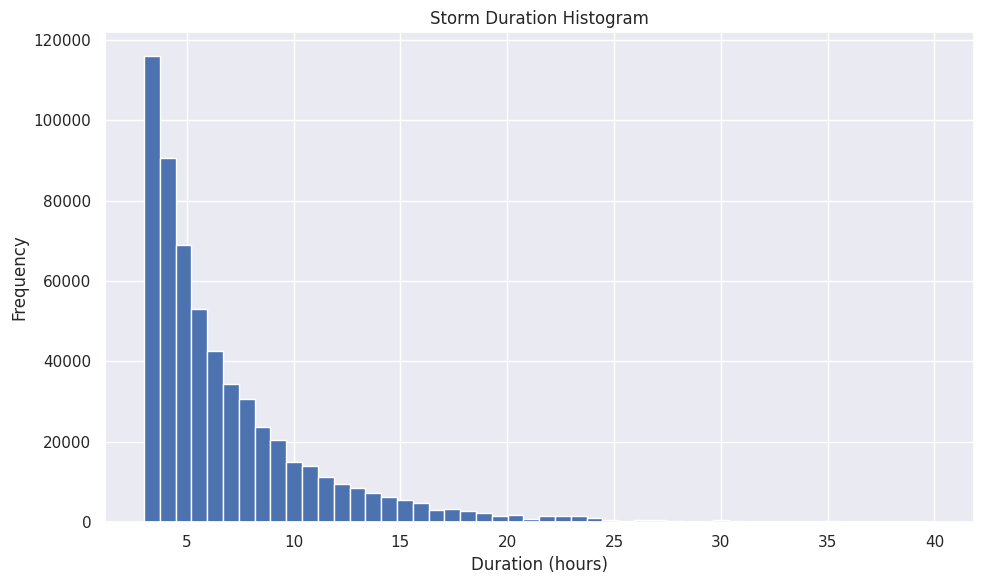

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["storm_total_duration"], bins=50)

plt.xlabel("Duration (hours)")
plt.ylabel("Frequency")
plt.title("Storm Duration Histogram")
plotting.save_plot("storm_duration_hist.png")

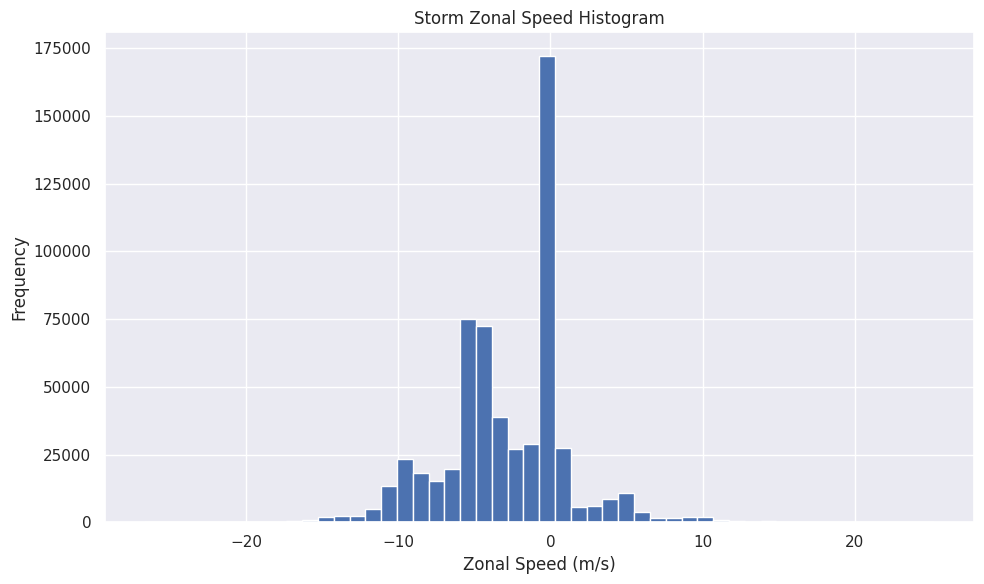

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["zonal_speed"], bins=50)

plt.xlabel("Zonal Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Storm Zonal Speed Histogram")
plotting.save_plot("storm_zonal_speed_hist.png")

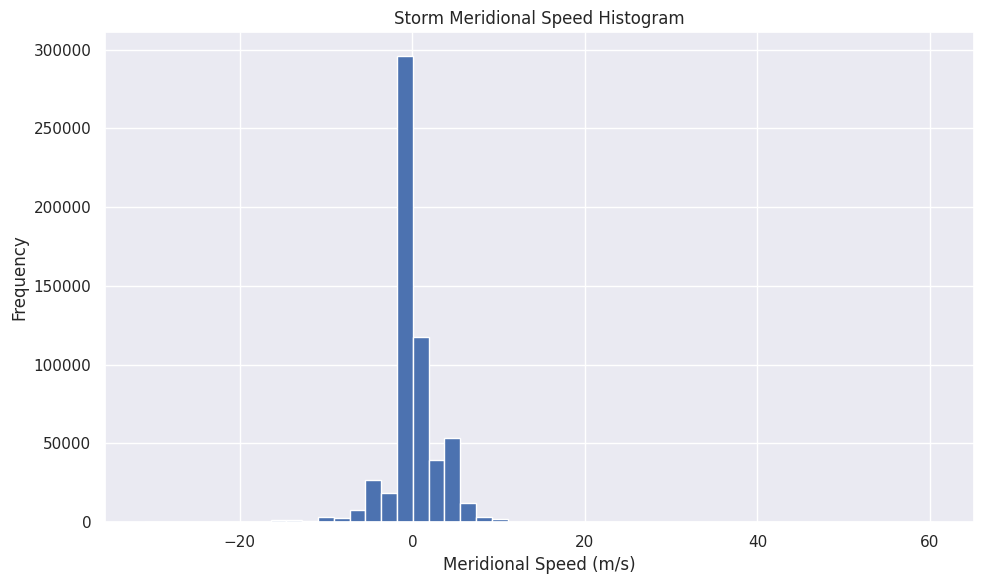

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["meridional_speed"], bins=50)

plt.xlabel("Meridional Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Storm Meridional Speed Histogram")
plotting.save_plot("storm_meridional_speed_hist.png")

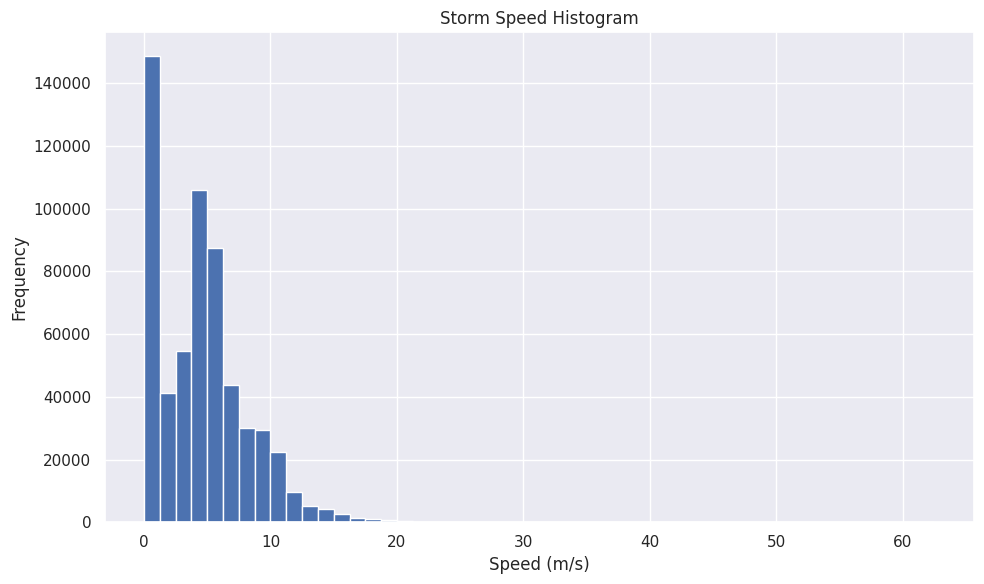

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(np.sqrt(df["zonal_speed"]**2 + df["meridional_speed"]**2) , bins=50)

plt.xlabel("Speed (m/s)")
plt.ylabel("Frequency")
plt.title("Storm Speed Histogram")
plotting.save_plot("storm_speed_hist.png")

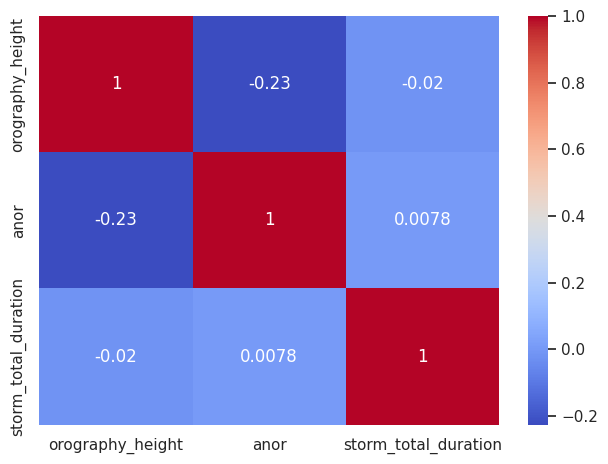

In [ ]:
sns.heatmap(
    df[["orography_height", "anor", "storm_total_duration"]].corr(),
    annot=True,
    cmap="coolwarm",
)
plotting.save_plot("orography_anor_correlation_heatmap.png")

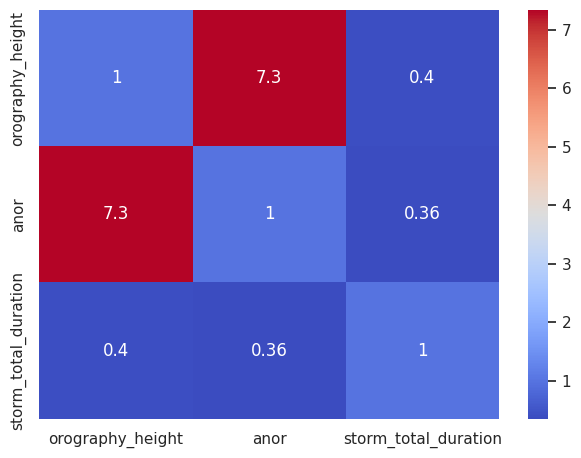

In [ ]:
sns.heatmap(
    df[["orography_height", "anor", "storm_total_duration"]].corr(
        method=lambda x, y: mutual_info_regression(
            x.reshape(-1, 1), y, discrete_features=False
        )[0]
    ),
    annot=True,
    cmap="coolwarm",
)
plotting.save_plot("orography_anor_mutual_info_heatmap.png")

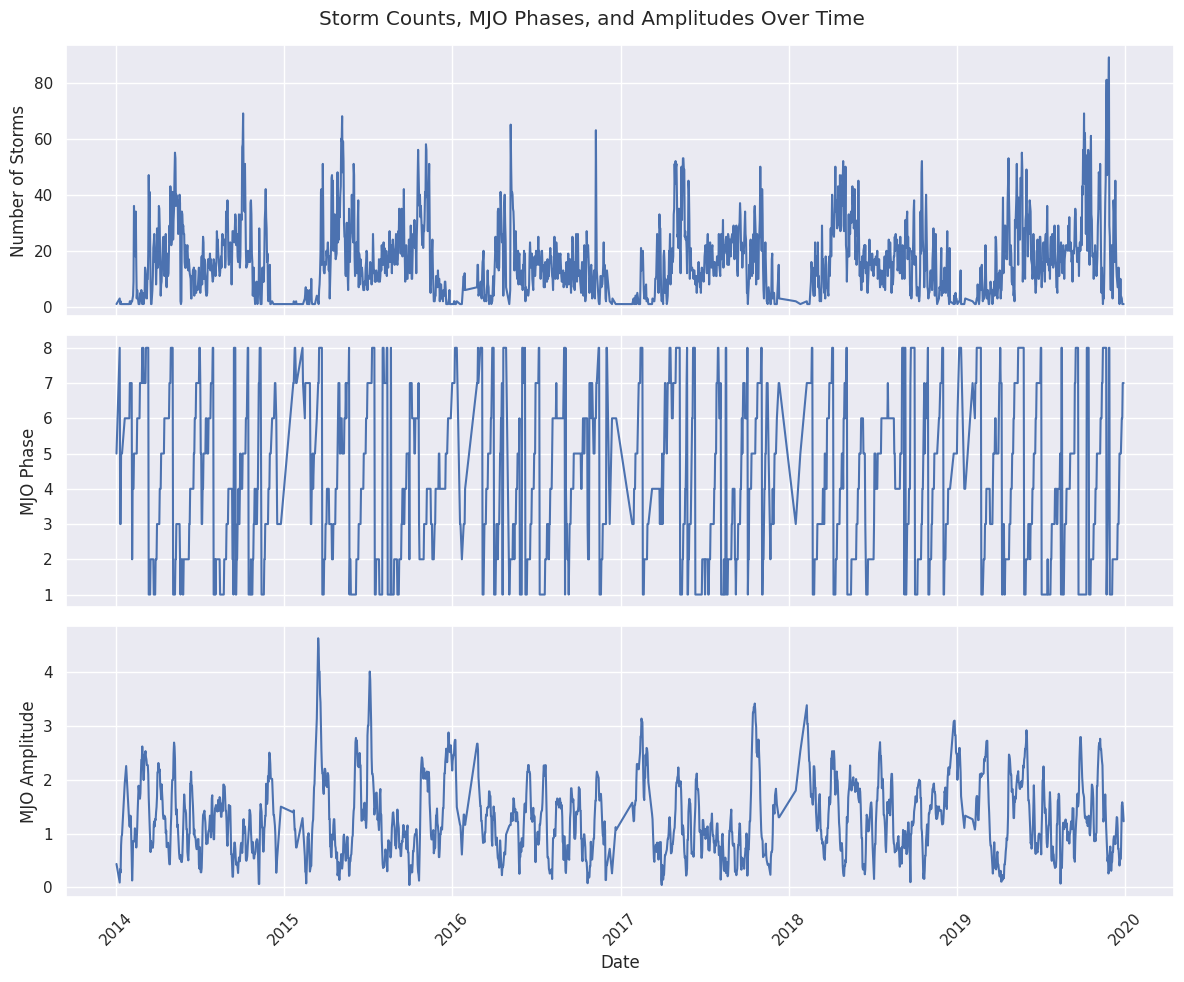

In [ ]:
df["date"] = pd.to_datetime(df["timestamp"]).dt.date
storm_counts = df.groupby("date")["storm_id"].nunique().reset_index()
storm_counts.columns = ["date", "storm_count"]

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
sns.lineplot(data=storm_counts, x="date", y="storm_count", ax=axs[0])
axs[0].set_ylabel("Number of Storms")

mjo_phases = df.groupby("date")["mjo_phase"].first().reset_index()
sns.lineplot(data=mjo_phases, x="date", y="mjo_phase", ax=axs[1])
axs[1].set_ylabel("MJO Phase")

mjo_ampls = df.groupby("date")["mjo_amplitude"].first().reset_index()
sns.lineplot(data=mjo_ampls, x="date", y="mjo_amplitude", ax=axs[2])
axs[2].set_ylabel("MJO Amplitude")
plt.xticks(rotation=45)
plt.xlabel("Date")

plt.suptitle("Storm Counts, MJO Phases, and Amplitudes Over Time")

plotting.save_plot("storm_counts_per_day_vs_mjo.png")